In [1]:
!pip install fuzzywuzzy

In [2]:
# ==============================================================================
# 0. IMPORTS
# ==============================================================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import ast
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from wordcloud import WordCloud
from collections import Counter
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import StandardScaler, MultiLabelBinarizer
from sklearn.decomposition import PCA
from sklearn.feature_selection import VarianceThreshold
from sklearn.metrics.pairwise import cosine_similarity
from scipy.sparse import hstack, csr_matrix
from sklearn.model_selection import train_test_split
from sklearn.metrics import ndcg_score
import joblib
from sentence_transformers import SentenceTransformer
from fuzzywuzzy import process # For better title matching


# Download NLTK resources if not already present
try:
    nltk.data.find('corpora/stopwords')
except LookupError:
    nltk.download('stopwords')
try:
    nltk.data.find('corpora/wordnet')
except LookupError:
    nltk.download('wordnet')

/usr/local/lib/python3.11/dist-packages/fuzzywuzzy/fuzz.py:11: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


Successfully loaded data from /content/clean_drama_dataset.csv. Shape: (2031, 18)

--- Initial Data Info ---

--- Data types ---
title                   object
year                     int64
rating                 float64
genres                  object
tags                    object
synopsis                object
directors               object
screenwriters           object
episodes                 int64
content_rating          object
original_network        object
aired                   object
aired_on                object
reviews                 object
duration_in_minutes      int64
cleaned_synopsis        object
cleaned_reviews         object
review_sentiment       float64
dtype: object

--- Descriptive Statistics ---
              year       rating     episodes  duration_in_minutes  \
count  2031.000000  2031.000000  2031.000000          2031.000000   
mean   2017.352043     7.621320    21.708026            49.839488   
std       5.420145     0.584111    24.776815            22.1

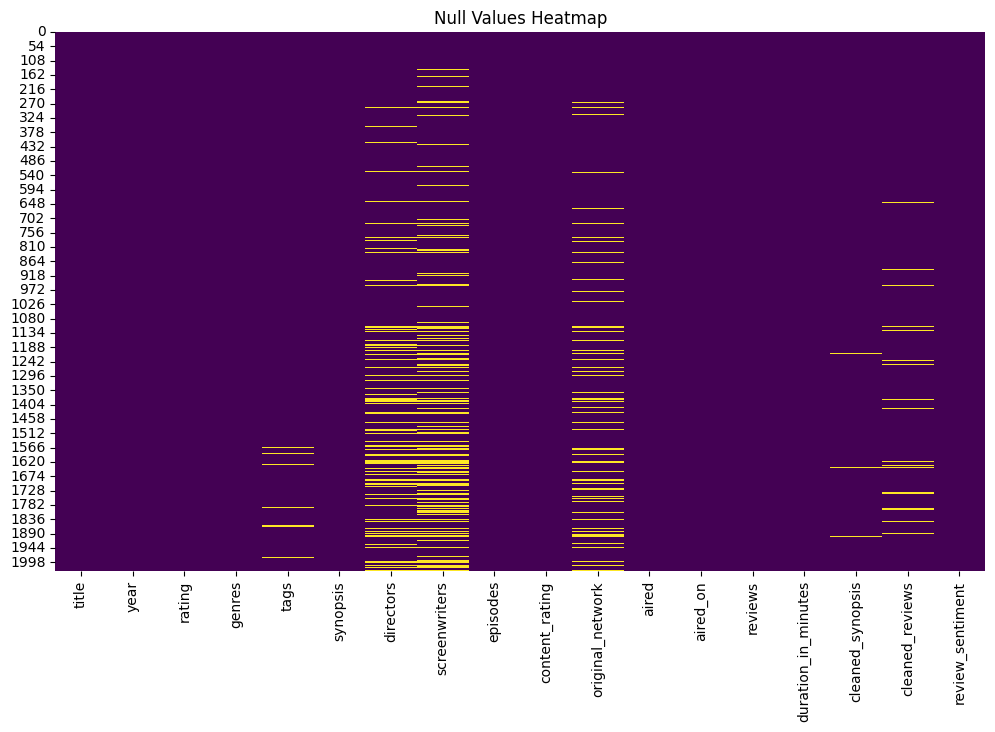

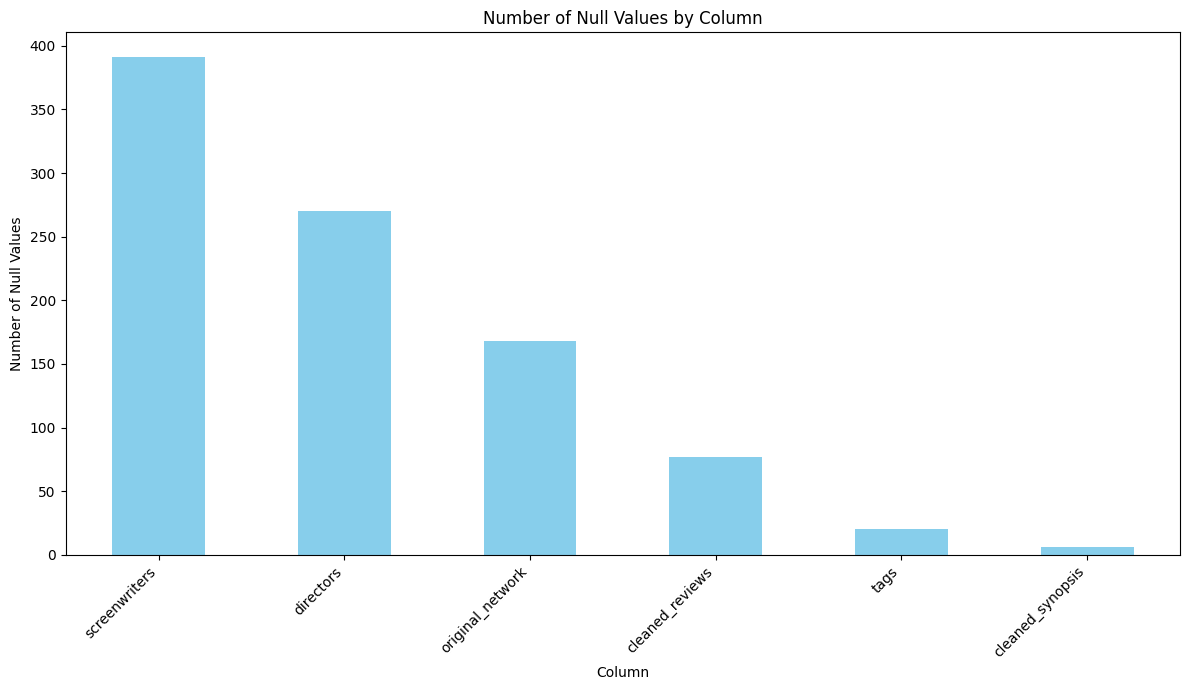


--- Numerical Feature Analysis ---
Numerical columns: ['year', 'rating', 'episodes', 'duration_in_minutes', 'review_sentiment']


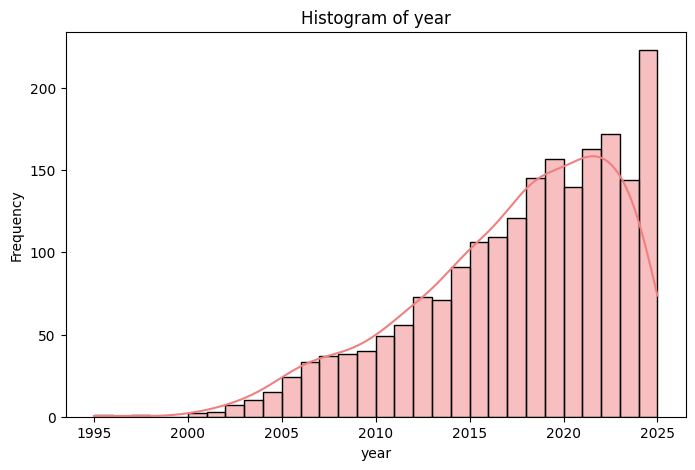

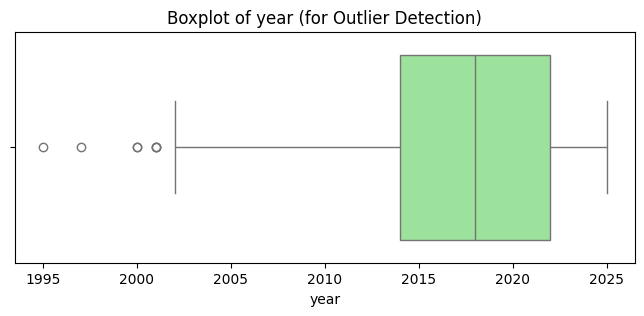

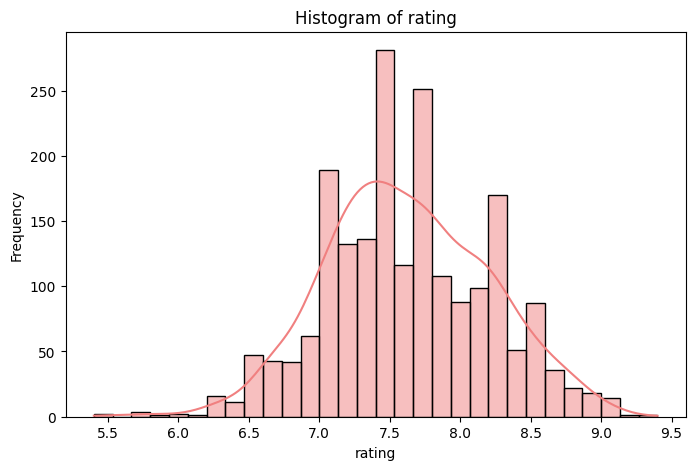

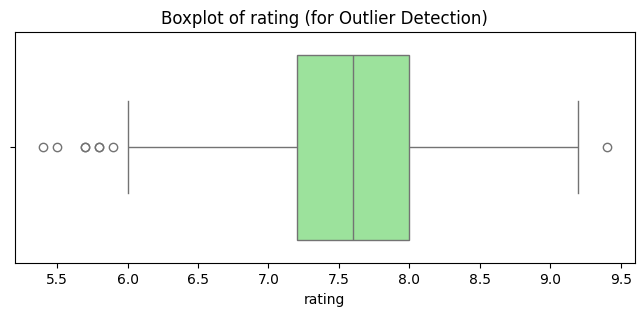

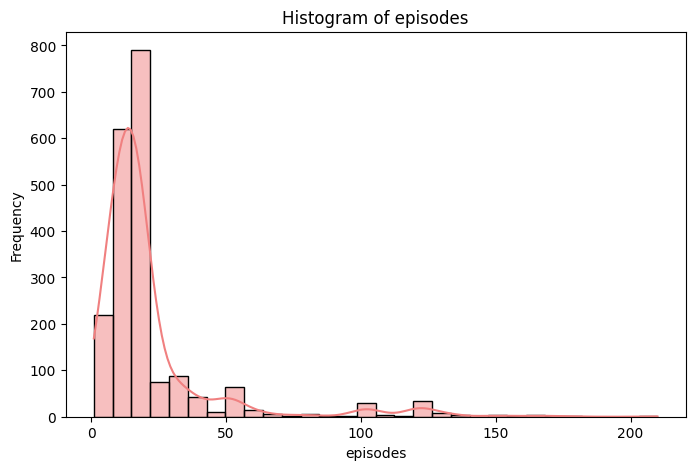

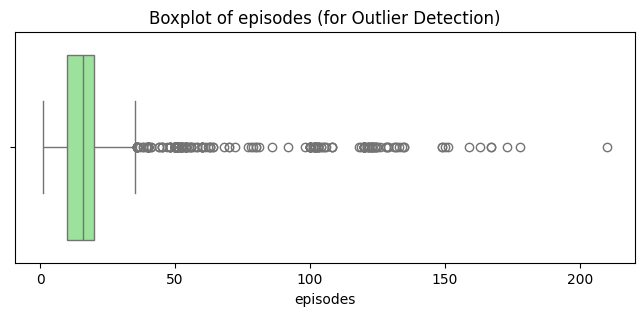

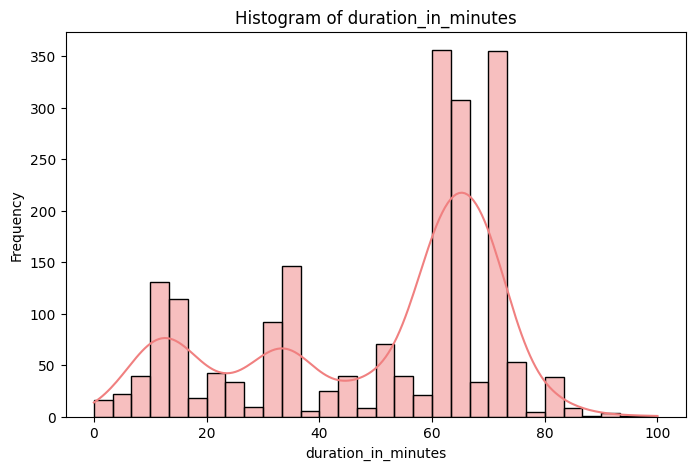

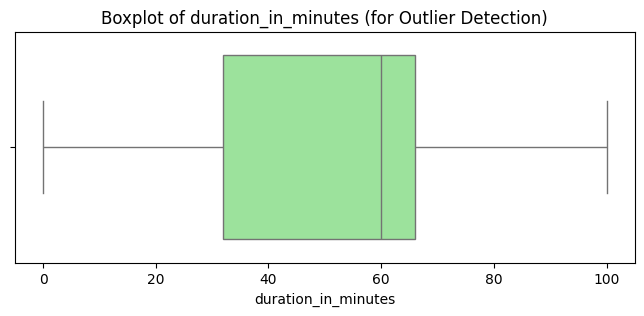

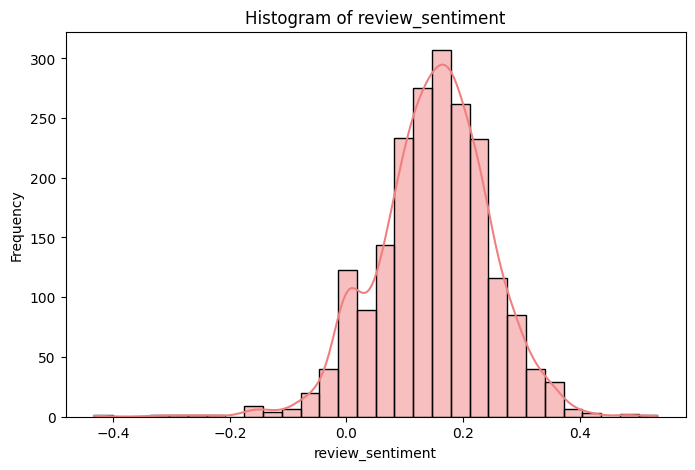

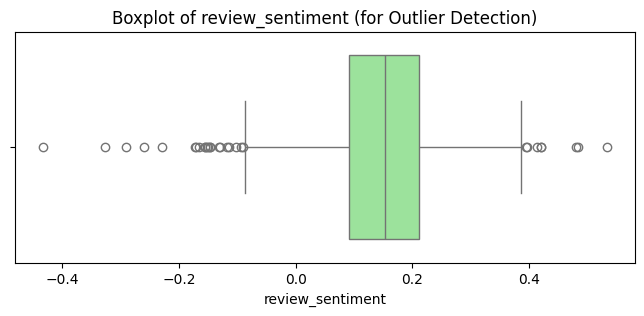

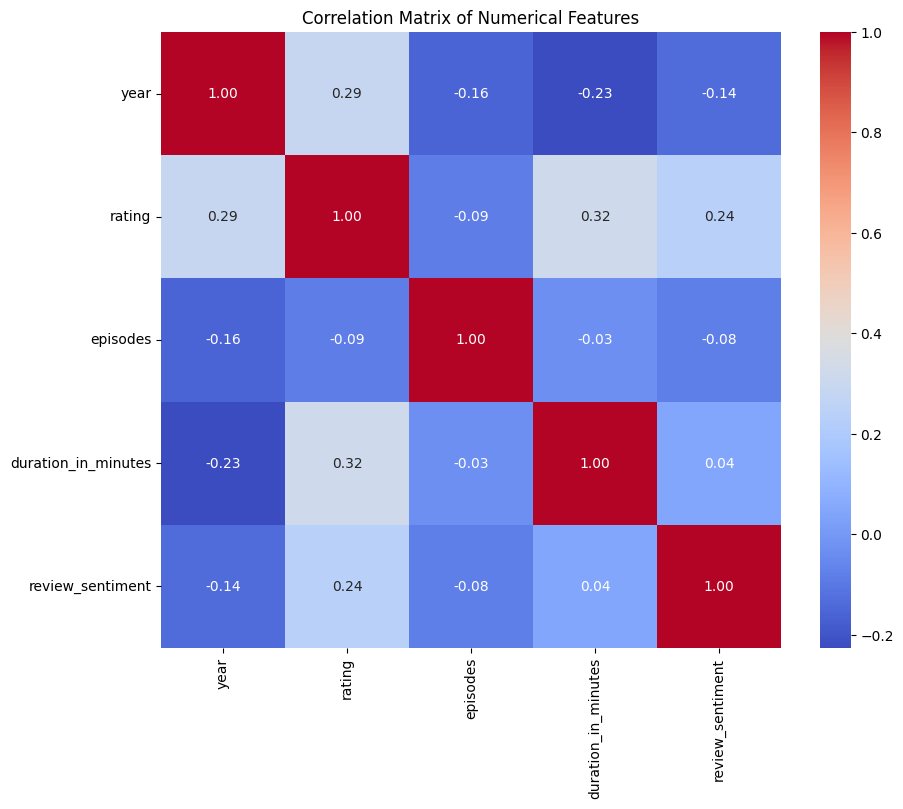


--- Categorical Feature Analysis ---


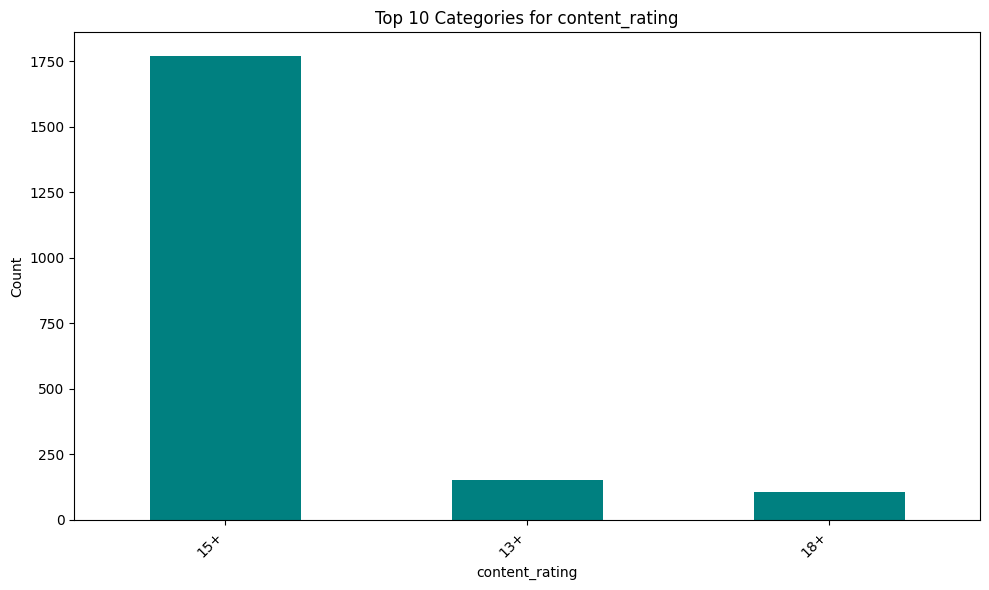

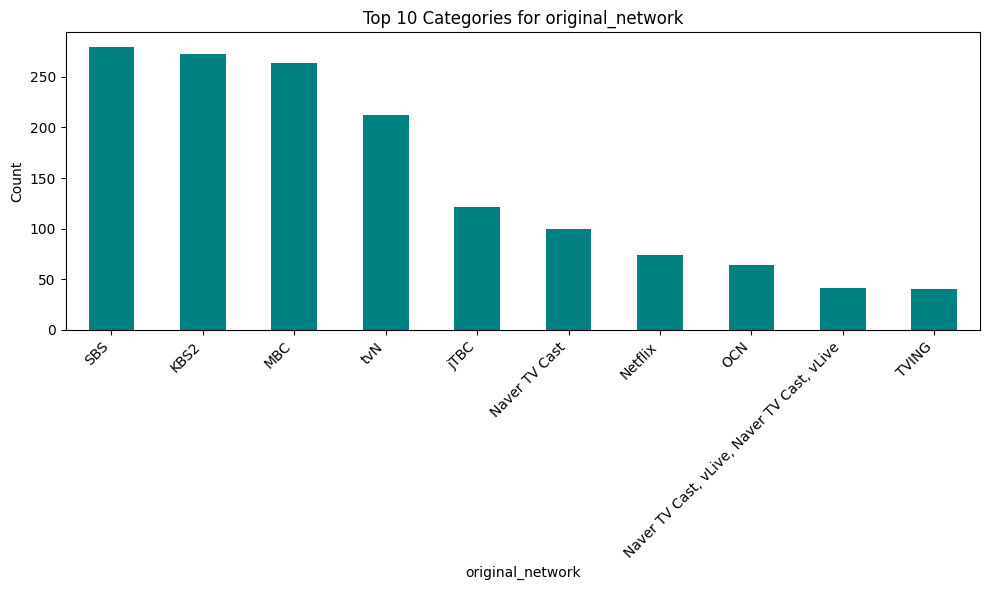

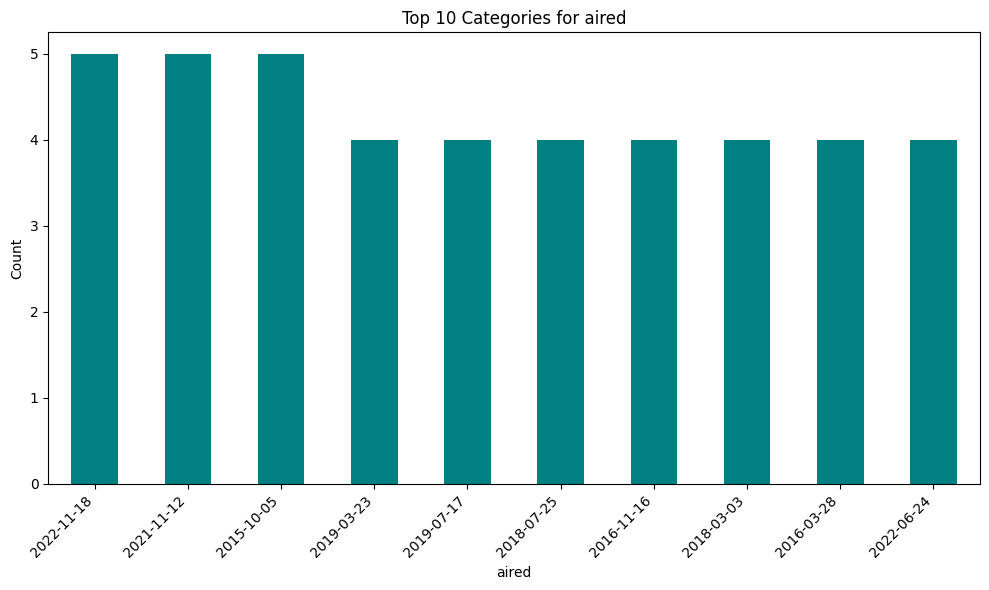

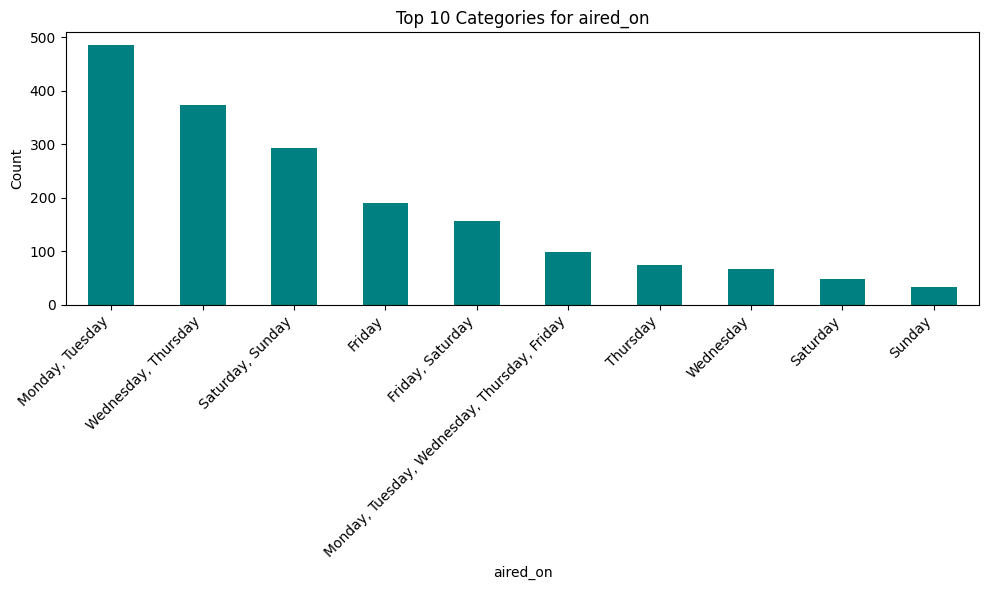


--- Text Data Analysis (Synopsis) ---


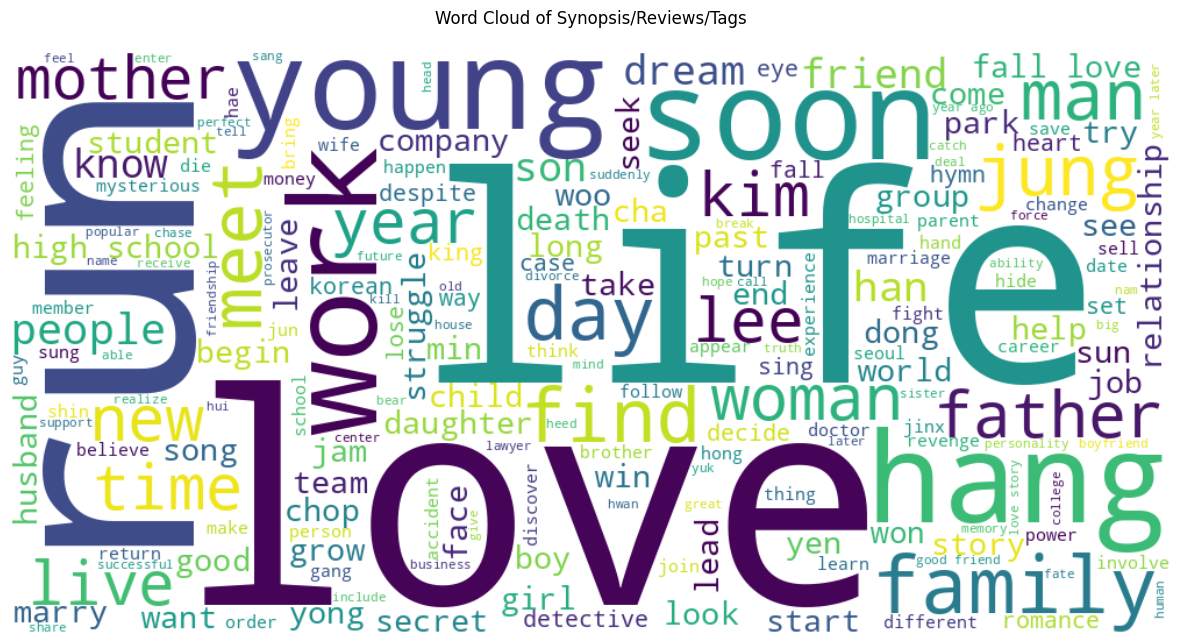

/tmp/ipython-input-1016863513.py:147: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(words), y=list(counts), palette='rocket')


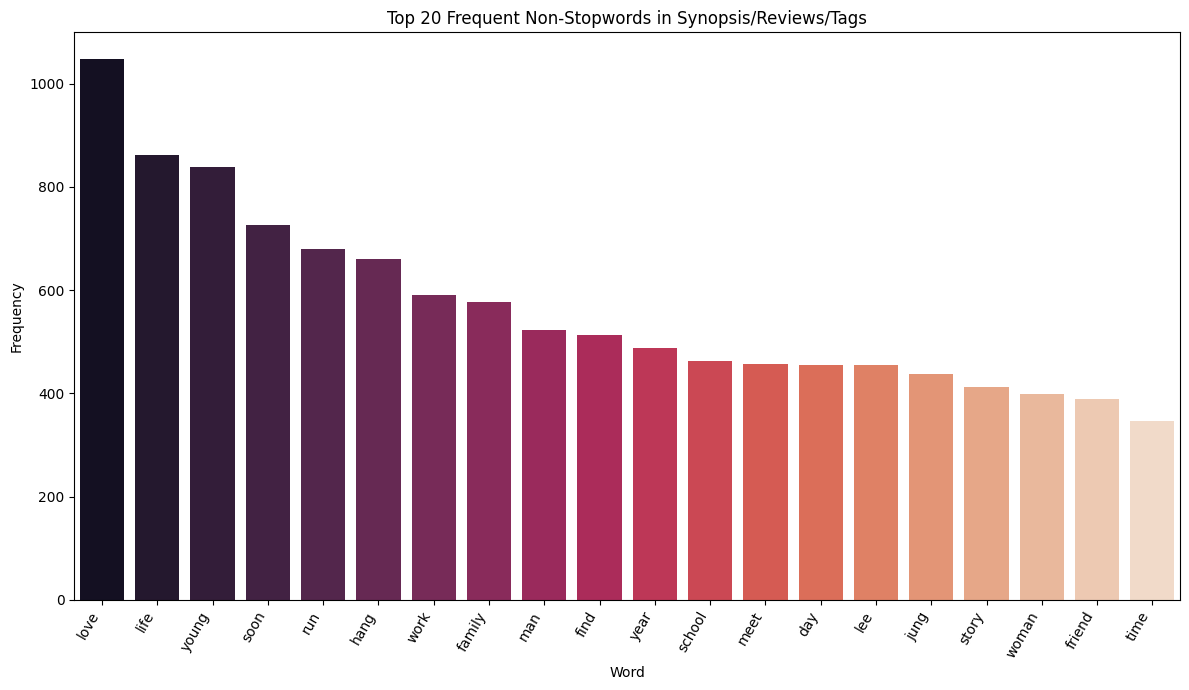

In [3]:
# ==============================================================================
# 1. DATA COLLECTION AND UNDERSTANDING
# ==============================================================================

def load_data(path):
    """
    Loads data from a CSV file.

    Args:
        path (str): The file path to the CSV dataset.

    Returns:
        pd.DataFrame: The loaded DataFrame, or None if an error occurs.
    """
    try:
        df = pd.read_csv(path)
        print(f"Successfully loaded data from {path}. Shape: {df.shape}")
        return df
    except FileNotFoundError:
        print(f"Error: File not found at {path}")
        return None
    except Exception as e:
        print(f"Error loading data: {e}")
        return None

# Load the dataset
# IMPORTANT: Replace '/content/clean_drama_dataset.csv' with the actual path
# to your dataset if running locally or in a different environment.
df = load_data('/content/clean_drama_dataset.csv')

if df is None:
    print("Exiting script due to data loading failure.")
    exit() # Exit if data loading fails

df_cpy = df.copy()

print("\n--- Initial Data Info ---")
df_cpy.head(6)
print(f'\n--- Data types ---\n{df_cpy.dtypes}')
print(f'\n--- Descriptive Statistics ---\n{df_cpy.describe()}')
df_cpy.info()

# Convert string representations of lists to actual lists
# Using ast.literal_eval for safe evaluation of string literals
list_cols = ['tags', 'directors', 'screenwriters', 'genres']
for col in list_cols:
    df_cpy[col] = df_cpy[col].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)
    # Replace empty lists with NaN for consistent handling later
    df_cpy[col] = df_cpy[col].apply(lambda x: np.nan if isinstance(x, list) and not x else x)
    print(f"Processed column '{col}' for list conversion.")

print("\n--- Data Info after list conversion ---")
df_cpy.info()
df_cpy.head(6)

# --- EDA: Null Value Analysis ---
print("\n--- Null Value Analysis ---")
null_counts = df_cpy.isnull().sum()
print(f'Null value counts by column:\n{null_counts[null_counts > 0]}')

null_pct = null_counts / len(df_cpy) * 100
print(f'Null value percentages by column:\n{null_pct[null_pct > 0].round(2)}')

plt.figure(figsize=(12, 7))
sns.heatmap(df_cpy.isnull(), cbar=False, cmap='viridis')
plt.title('Null Values Heatmap')
plt.show()

plt.figure(figsize=(12, 7))
null_counts[null_counts > 0].sort_values(ascending=False).plot(kind='bar', color='skyblue')
plt.title('Number of Null Values by Column')
plt.xlabel('Column')
plt.ylabel('Number of Null Values')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# --- EDA: Numerical Feature Analysis ---
print("\n--- Numerical Feature Analysis ---")
numeric_cols = df_cpy.select_dtypes(include=['int64', 'float64']).columns.tolist()
print(f'Numerical columns: {numeric_cols}')

for col in numeric_cols:
    plt.figure(figsize=(8, 5))
    sns.histplot(df_cpy[col].dropna(), kde=True, bins=30, color='lightcoral')
    plt.title(f'Histogram of {col}')
    plt.xlabel(col)
    plt.ylabel('Frequency')
    plt.show()

    plt.figure(figsize=(8, 3))
    sns.boxplot(x=df_cpy[col].dropna(), color='lightgreen')
    plt.title(f'Boxplot of {col} (for Outlier Detection)')
    plt.xlabel(col)
    plt.show()

# Correlation Heatmap for numerical features
if len(numeric_cols) > 1:
    plt.figure(figsize=(10, 8))
    sns.heatmap(df_cpy[numeric_cols].corr(), annot=True, cmap='coolwarm', fmt=".2f")
    plt.title("Correlation Matrix of Numerical Features")
    plt.show()

# --- EDA: Categorical Feature Analysis ---
print("\n--- Categorical Feature Analysis ---")
# Identify categorical columns that are not lists (already handled above)
# and are not numerical or text synopsis/reviews
categorical_cols = ['content_rating', 'original_network', 'aired', 'aired_on']

for col in categorical_cols:
    if col in df_cpy.columns:
        plt.figure(figsize=(10, 6))
        df_cpy[col].value_counts().head(10).plot(kind='bar', color='teal')
        plt.title(f'Top 10 Categories for {col}')
        plt.xlabel(col)
        plt.ylabel('Count')
        plt.xticks(rotation=45, ha='right')
        plt.tight_layout()
        plt.show()

# --- EDA: Text Data Analysis (Synopsis) ---
print("\n--- Text Data Analysis (Synopsis) ---")
# Combine all cleaned synopsis text into a single string for word cloud
# Ensure 'cleaned_synopsis' exists or use 'synopsis' if not yet cleaned
text_data_col = 'cleaned_synopsis' if 'cleaned_synopsis' in df_cpy.columns else 'synopsis'
text_data = ' '.join(df_cpy[text_data_col].dropna().astype(str).values)

if text_data:
    plt.figure(figsize=(15, 8))
    wordcloud = WordCloud(width=1000, height=500, background_color='white', colormap='viridis').generate(text_data)
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title('Word Cloud of Synopsis/Reviews/Tags\n')
    plt.show()

    # Top frequent words
    words = text_data.lower().split()
    word_freq = Counter(words)
    # Exclude common stopwords from this specific count for better insights
    filtered_words = [word for word in words if word not in stopwords.words('english')]
    word_freq_filtered = Counter(filtered_words)
    most_common = word_freq_filtered.most_common(20)

    if most_common:
        words, counts = zip(*most_common)
        plt.figure(figsize=(12, 7))
        sns.barplot(x=list(words), y=list(counts), palette='rocket')
        plt.xticks(rotation=60, ha='right')
        plt.title("Top 20 Frequent Non-Stopwords in Synopsis/Reviews/Tags")
        plt.xlabel("Word")
        plt.ylabel("Frequency")
        plt.tight_layout()
        plt.show()
else:
    print("No text data available for word cloud or frequent word analysis.")




--- Data Cleaning and Pre-processing ---
No columns had >50% null values to drop.
Filled 'year' with mode: 2022
Filled 'directors' with 'Unknown'
Filled 'screenwriters' with 'Unknown'
Filled 'cleaned_synopsis' with 'Unknown'
Filled 'cleaned_reviews' with 'Unknown'
Filled empty lists in 'genres' with mode: ['Comedy', 'Romance', 'Drama']
Filled empty lists in 'tags' with mode: ['Short Length Series', 'Miniseries', 'Web Series']
Filled 'content_rating' with mode: 15+
Filled 'original_network' with mode: SBS
Filled 'aired' with mode: 2015-10-05
Filled 'aired_on' with mode: Monday, Tuesday
Filled 'episodes' with mode: 16
Filled 'rating' with mean: 7.62
Filled 'duration_in_minutes' with mean: 49.84
No rows dropped for missing values in "title"

--- Null values after imputation/dropping ---
Series([], dtype: int64)
All specified null values handled.

--- Outlier Handling (IQR Capping) ---
Capped outliers for column: year
Capped outliers for column: rating
Capped outliers for column: episodes

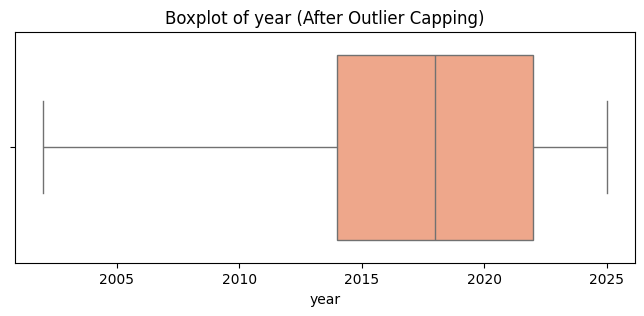

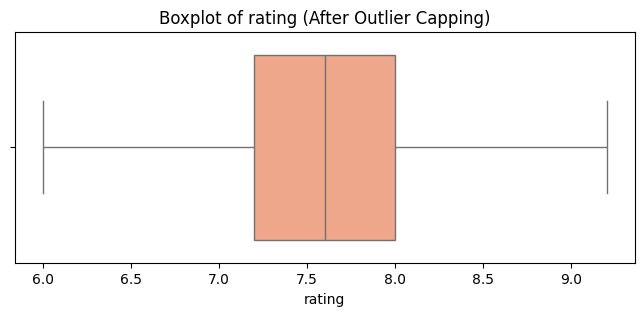

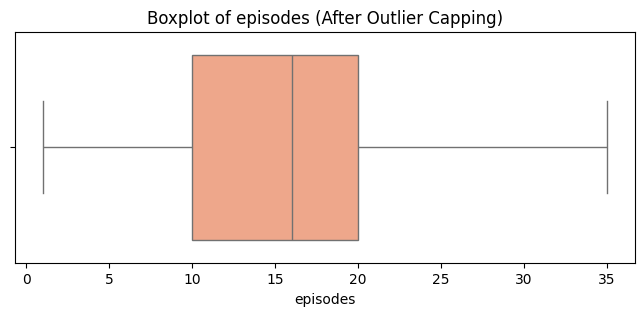

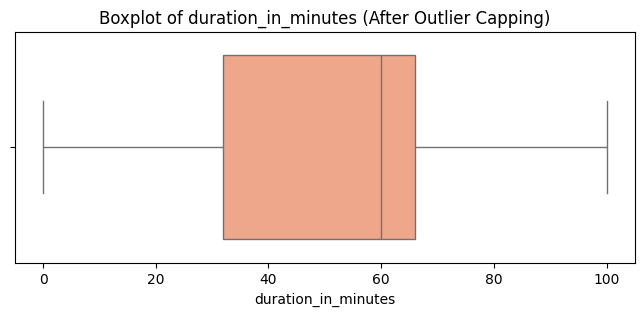

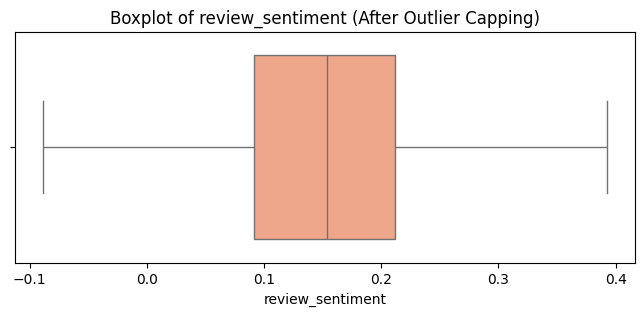


--- Duplicate Handling ---
Number of duplicate rows by title: 7
Removed 7 duplicate rows. New shape: (2024, 18)

--- Text Cleaning ---
Text cleaning applied to title, synopsis, reviews, tags, directors, genres.
                            title               cleaned_title  \
0  When Life Gives You Tangerines         life give tangerine   
1            Twinkling Watermelon        twinkling watermelon   
2                  Move to Heaven                 move heaven   
3      Hospital Playlist Season 2  hospital playlist season 2   
4               Weak Hero Class 1           weak hero class 1   

                                      flattened_tags  
0  healthy main relationship family relationship ...  
1  time travel child future deafness sign languag...  
2  unclenephew relationship autism death tearjerk...  
3  multiple main band music multiple couple comed...  
4  student male lead teenager male lead violence ...  


In [4]:
# ==============================================================================
# 2. DATA PRE-PROCESSING
# ==============================================================================

print("\n--- Data Cleaning and Pre-processing ---")

# --- 2.1 Data Cleaning ---

# Handle null values: Drop columns with more than 50% null values
high_null_cols = [col for col in df_cpy.columns if (df_cpy[col].isnull().mean() * 100) > 50]
if high_null_cols:
    df_cpy = df_cpy.drop(columns=high_null_cols)
    print(f"Dropped columns with >50% nulls: {high_null_cols}")
else:
    print("No columns had >50% null values to drop.")

# Define imputation strategies for remaining null values
fill_unkwn_col = ['directors', 'screenwriters', 'cleaned_synopsis', 'cleaned_reviews']
fill_mode_yr = ['year'] # Year is treated separately as it was a list-like string
fill_mode = ['content_rating', 'original_network', 'aired', 'aired_on', 'episodes'] # Non-list columns
fill_list_mode = ['genres', 'tags'] # List columns that need special handling
fill_mean = ['rating', 'duration_in_minutes']
drop_rw = ['title'] # Rows with missing titles will be dropped

# Impute 'year' with mode (after converting to numeric if necessary)
if 'year' in df_cpy.columns:
    df_cpy['year'] = pd.to_numeric(df_cpy['year'], errors='coerce') # Ensure it's numeric
    mode_val_year = df_cpy['year'].dropna().mode()[0]
    df_cpy['year'] = df_cpy['year'].fillna(mode_val_year)
    print(f"Filled 'year' with mode: {mode_val_year}")

# Impute other columns
for col in fill_unkwn_col:
    if col in df_cpy.columns:
        df_cpy[col] = df_cpy[col].fillna('Unknown')
        print(f"Filled '{col}' with 'Unknown'")

# Handle list columns separately - robust approach
for col in fill_list_mode:
    if col in df_cpy.columns:
        # Find the most common non-empty list
        non_empty = df_cpy[col].dropna()
        if len(non_empty) > 0:
            # Get the first mode value
            mode_val = non_empty.value_counts().index[0]

            # Convert all values to lists if they aren't already
            df_cpy[col] = df_cpy[col].apply(lambda x: x if isinstance(x, list) else [])

            # Replace empty lists with mode
            df_cpy[col] = df_cpy[col].apply(lambda x: mode_val if len(x) == 0 else x)

            print(f"Filled empty lists in '{col}' with mode: {mode_val}")
        else:
            # If no mode exists, ensure all values are lists
            df_cpy[col] = df_cpy[col].apply(lambda x: x if isinstance(x, list) else [])
            print(f"Ensured all values in '{col}' are lists (no mode available)")

# Handle non-list columns with mode
for col in fill_mode:
    if col in df_cpy.columns:
        mode_val = df_cpy[col].dropna().mode()
        if not mode_val.empty:
            mode_val = mode_val[0]
            df_cpy[col] = df_cpy[col].fillna(mode_val)
            print(f"Filled '{col}' with mode: {mode_val}")
        else:
            print(f"Warning: Could not determine mode for '{col}', leaving NaNs if any exist.")

# Handle numerical columns with mean
for col in fill_mean:
    if col in df_cpy.columns:
        mean_val = df_cpy[col].dropna().mean()
        df_cpy[col] = df_cpy[col].fillna(mean_val)
        print(f"Filled '{col}' with mean: {mean_val:.2f}")

# Drop rows with missing values in critical columns like 'title'
for col in drop_rw:
    if col in df_cpy.columns:
        initial_rows = len(df_cpy)
        df_cpy = df_cpy.dropna(subset=[col])
        dropped_rows = initial_rows - len(df_cpy)
        if dropped_rows > 0:
            print(f'Dropped {dropped_rows} rows with missing values in "{col}"')
        else:
            print(f'No rows dropped for missing values in "{col}"')

# Verify no more nulls in critical columns
print("\n--- Null values after imputation/dropping ---")
print(df_cpy.isnull().sum()[df_cpy.isnull().sum() > 0])
if df_cpy.isnull().sum().sum() == 0:
    print("All specified null values handled.")
else:
    print("Warning: Some null values still exist. Review output above.")

# Handle outliers using IQR capping
print("\n--- Outlier Handling (IQR Capping) ---")
# Re-identify numerical columns after potential drops/imputations
numeric_cols = df_cpy.select_dtypes(include=['int64', 'float64']).columns.tolist()
if numeric_cols:
    Q1 = df_cpy[numeric_cols].quantile(0.25)
    Q3 = df_cpy[numeric_cols].quantile(0.75)
    IQR = Q3 - Q1
    UP = Q3 + (1.5 * IQR)
    LB = Q1 - (1.5 * IQR)

    df_capped = df_cpy.copy()
    for col in numeric_cols:
        df_capped[col] = np.where(df_cpy[col] > UP[col], UP[col], np.where(df_cpy[col] < LB[col], LB[col], df_cpy[col]))
        print(f"Capped outliers for column: {col}")

    # Assign capped values back to the original DataFrame
    df_cpy[numeric_cols] = df_capped[numeric_cols]

    # Visualize boxplots after capping
    for col in numeric_cols:
        plt.figure(figsize=(8, 3))
        sns.boxplot(x=df_cpy[col], color='lightsalmon')
        plt.title(f'Boxplot of {col} (After Outlier Capping)')
        plt.xlabel(col)
        plt.show()
else:
    print("No numerical columns found for outlier handling.")

# Handle duplicate rows based on 'title'
print("\n--- Duplicate Handling ---")
duplicate_count = df_cpy['title'].duplicated().sum()
print(f'Number of duplicate rows by title: {duplicate_count}')

if duplicate_count > 0:
    df_cpy.drop_duplicates(subset='title', keep='first', inplace=True)
    print(f'Removed {duplicate_count} duplicate rows. New shape: {df_cpy.shape}')
else:
    print("No duplicate rows by title found.")

# --- 2.2 Clean Text Fields ---
print("\n--- Text Cleaning ---")
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def clean_text(text):
    """
    Cleans a given text string: lowercases, removes HTML tags, special chars,
    stopwords, and lemmatizes.
    """
    if not isinstance(text, str):
        return "" # Return empty string for non-string inputs
    text = text.lower()
    text = re.sub(r'<.*?>', '', text) # Remove HTML tags
    text = re.sub(r'[^a-zA-Z0-9\s]', '', text) # Remove special characters
    words = text.split()
    text = " ".join([lemmatizer.lemmatize(word) for word in words if word not in stop_words])
    return text

def clean_list_field(field_list):
    """
    Cleans a list of strings (e.g., tags, directors, genres).
    Applies clean_text to each item in the list.
    """
    if not isinstance(field_list, list):
        return []
    return [clean_text(item) for item in field_list if isinstance(item, str)]

# Apply text cleaning to relevant columns
df_cpy['cleaned_title'] = df_cpy['title'].apply(clean_text)
df_cpy['cleaned_synopsis'] = df_cpy['synopsis'].apply(clean_text)
df_cpy['cleaned_reviews'] = df_cpy['reviews'].apply(clean_text)

# Apply cleaning to list-like fields and flatten them for TF-IDF/BERT
df_cpy['cleaned_tags'] = df_cpy['tags'].apply(clean_list_field)
df_cpy['flattened_tags'] = df_cpy['cleaned_tags'].apply(lambda x: " ".join(x))

df_cpy['cleaned_directors'] = df_cpy['directors'].apply(clean_list_field)
df_cpy['flattened_directors'] = df_cpy['cleaned_directors'].apply(lambda x: " ".join(x))

df_cpy['cleaned_genres'] = df_cpy['genres'].apply(clean_list_field)
df_cpy['flattened_genres'] = df_cpy['cleaned_genres'].apply(lambda x: " ".join(x))

print("Text cleaning applied to title, synopsis, reviews, tags, directors, genres.")
print(df_cpy[['title', 'cleaned_title', 'flattened_tags']].head())



In [5]:
# ==============================================================================
# 2.3 FEATURE ENGINEERING
# ==============================================================================

print("\n--- Feature Engineering ---")

# --- Text-based Features (TF-IDF) ---
# Using min_df to ignore terms that appear in too few documents
tfidf_syn = TfidfVectorizer(max_features=5000, stop_words='english', min_df=5)
synopsis_tfidf = tfidf_syn.fit_transform(df_cpy['cleaned_synopsis'])
print(f"TF-IDF for synopsis created. Shape: {synopsis_tfidf.shape}")

tfidf_reviews = TfidfVectorizer(max_features=5000, stop_words='english', min_df=5)
reviews_tfidf = tfidf_reviews.fit_transform(df_cpy['cleaned_reviews'])
print(f"TF-IDF for reviews created. Shape: {reviews_tfidf.shape}")

tfidf_tags = TfidfVectorizer(max_features=1000, stop_words='english', min_df=3)
tags_tfidf = tfidf_tags.fit_transform(df_cpy['flattened_tags'])
print(f"TF-IDF for tags created. Shape: {tags_tfidf.shape}")

tfidf_directors = TfidfVectorizer(max_features=500, stop_words='english', min_df=2)
directors_tfidf = tfidf_directors.fit_transform(df_cpy['flattened_directors'])
print(f"TF-IDF for directors created. Shape: {directors_tfidf.shape}")

tfidf_genres = TfidfVectorizer(max_features=500, stop_words='english', min_df=2)
genres_tfidf = tfidf_genres.fit_transform(df_cpy['flattened_genres'])
print(f"TF-IDF for genres created. Shape: {genres_tfidf.shape}")


# --- Semantic Embeddings (BERT) ---
# Using a pre-trained Sentence-BERT model for dense semantic embeddings
print("\nLoading Sentence-BERT model (this may take a moment)...")
try:
    bert_model = SentenceTransformer('all-MiniLM-L6-v2')
    # Encode text features into BERT embeddings
    bert_synopsis = bert_model.encode(df_cpy['cleaned_synopsis'].tolist(), show_progress_bar=True)
    bert_reviews = bert_model.encode(df_cpy['cleaned_reviews'].tolist(), show_progress_bar=True)
    bert_tags = bert_model.encode(df_cpy['flattened_tags'].tolist(), show_progress_bar=True)
    print(f"BERT embeddings created. Synopsis shape: {bert_synopsis.shape}")
except Exception as e:
    print(f"Error loading or using Sentence-BERT: {e}")
    print("Proceeding without BERT embeddings. This might impact recommendation quality.")
    bert_model = None
    bert_synopsis, bert_reviews, bert_tags = None, None, None


# --- General Features ---
df_cpy['title_length'] = df_cpy['title'].apply(len)
df_cpy['title_word_count'] = df_cpy['title'].apply(lambda x: len(str(x).split()))
df_cpy['has_season'] = df_cpy['title'].str.lower().str.contains('season').astype(int)

# Time-based features
df_cpy['decade'] = (df_cpy['year'] // 10) * 10
df_cpy['is_modern'] = (df_cpy['year'] > 2015).astype(int) # Example threshold for 'modern'

# Interaction/Composite features
df_cpy['num_tags'] = df_cpy['cleaned_tags'].apply(lambda x: len(x) if isinstance(x, list) else 0)
# Ensure 'episodes' is numeric before scaling
df_cpy['episodes'] = pd.to_numeric(df_cpy['episodes'], errors='coerce').fillna(df_cpy['episodes'].mean())
df_cpy['rating_per_episode'] = df_cpy['rating'] / (df_cpy['episodes'] + 1e-6) # Add small epsilon to avoid division by zero

print("General features engineered.")

# --- Scaling Numerical Features ---
scaler = StandardScaler()
# Select numerical columns for scaling, excluding those used for other feature types
numerical_features_for_scaling = [
    'rating', 'review_sentiment', 'episodes', 'duration_in_minutes',
    'title_length', 'title_word_count', 'num_tags', 'rating_per_episode'
]
# Filter to ensure only existing columns are selected
numerical_features_for_scaling = [col for col in numerical_features_for_scaling if col in df_cpy.columns]

if numerical_features_for_scaling:
    df_cpy[numerical_features_for_scaling] = scaler.fit_transform(df_cpy[numerical_features_for_scaling])
    print(f"Scaled numerical features: {numerical_features_for_scaling}")
else:
    print("No numerical features found for standard scaling.")


# --- One-Hot Encoding Categorical Features ---
# For multi-label columns like 'genres', MultiLabelBinarizer is appropriate
mlb_genres = MultiLabelBinarizer()
# Ensure 'genres' column is a list of lists or empty list for each row
df_cpy['genres'] = df_cpy['genres'].apply(lambda x: x if isinstance(x, list) else [])
genre_dummies = pd.DataFrame(mlb_genres.fit_transform(df_cpy['genres']),
                             columns=[f'genre_{c}' for c in mlb_genres.classes_],
                             index=df_cpy.index)
df_cpy = pd.concat([df_cpy, genre_dummies], axis=1)
print(f"One-hot encoded genres. Added {len(mlb_genres.classes_)} columns.")

# For single-label categorical columns, use pd.get_dummies
# Ensure 'content_rating' and 'original_network' are strings
df_cpy['content_rating'] = df_cpy['content_rating'].astype(str)
df_cpy['original_network'] = df_cpy['original_network'].astype(str)

cat_dummies = pd.get_dummies(df_cpy[['content_rating', 'original_network']], prefix=['content', 'network'])
df_cpy = pd.concat([df_cpy, cat_dummies], axis=1)
print(f"One-hot encoded content_rating and original_network. Added {cat_dummies.shape[1]} columns.")

print(f"\nDataFrame shape after feature engineering: {df_cpy.shape}")
print("Nulls after initial feature engineering:")
print(df_cpy.isnull().sum()[df_cpy.isnull().sum() > 0])

# Final check and drop rows with any remaining NaNs if critical
initial_rows = len(df_cpy)
df_cpy.dropna(inplace=True)
if len(df_cpy) < initial_rows:
    print(f"Dropped {initial_rows - len(df_cpy)} rows with remaining NaNs after feature engineering.")
print(f"Final DataFrame shape before dimensionality reduction: {df_cpy.shape}")




--- Feature Engineering ---
TF-IDF for synopsis created. Shape: (2024, 2852)
TF-IDF for reviews created. Shape: (2024, 5000)
TF-IDF for tags created. Shape: (2024, 924)
TF-IDF for directors created. Shape: (2024, 199)
TF-IDF for genres created. Shape: (2024, 32)

Loading Sentence-BERT model (this may take a moment)...


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Batches:   0%|          | 0/64 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Batches:   0%|          | 0/64 [00:00<?, ?it/s]

Batches:   0%|          | 0/64 [00:00<?, ?it/s]

BERT embeddings created. Synopsis shape: (2024, 384)
General features engineered.
Scaled numerical features: ['rating', 'review_sentiment', 'episodes', 'duration_in_minutes', 'title_length', 'title_word_count', 'num_tags', 'rating_per_episode']
One-hot encoded genres. Added 31 columns.
One-hot encoded content_rating and original_network. Added 103 columns.

DataFrame shape after feature engineering: (2024, 166)
Nulls after initial feature engineering:
Series([], dtype: int64)
Final DataFrame shape before dimensionality reduction: (2024, 166)


In [6]:
# ==============================================================================
# 2.4 DIMENSIONALITY REDUCTION
# ==============================================================================

print("\n--- Dimensionality Reduction ---")

# --- Feature Selection (Variance Threshold) ---
# Identify numerical columns for variance thresholding. Exclude one-hot encoded and original text columns.
numerical_cols_for_vt = df_cpy.select_dtypes(include=[np.number]).columns.tolist()
# Exclude one-hot encoded columns from this step if they were just created and are already sparse/binary
# The genre_dummies and cat_dummies are already essentially 'selected'
# Focus on original numerical features and engineered numerical features
numerical_cols_for_vt = [col for col in numerical_cols_for_vt if not (col.startswith('genre_') or col.startswith('content_') or col.startswith('network_'))]

# Remove columns that are constant or near-constant (e.g., if all values are 0 or 1 for a binary feature)
# This is especially useful after one-hot encoding where some categories might be very rare
# For simplicity, we'll apply it to a broad set of numerical features
X_numeric_for_vt = df_cpy[numerical_cols_for_vt]

if not X_numeric_for_vt.empty:
    selector = VarianceThreshold(threshold=0.01) # A slightly lower threshold to keep more features
    selector.fit(X_numeric_for_vt)
    kept_column_mask = selector.get_support()
    kept_numerical_cols = X_numeric_for_vt.columns[kept_column_mask].tolist()
    print(f"Variance Threshold: Kept {len(kept_numerical_cols)} out of {len(numerical_cols_for_vt)} numerical features.")
    df_cpy_reduced = df_cpy.drop(columns=numerical_cols_for_vt).copy()
    df_cpy_reduced = pd.concat([df_cpy_reduced, df_cpy[kept_numerical_cols]], axis=1)
else:
    df_cpy_reduced = df_cpy.copy()
    kept_numerical_cols = []
    print("No numerical columns suitable for Variance Thresholding or all were dropped.")

print(f"DataFrame shape after Variance Threshold: {df_cpy_reduced.shape}")


# --- PCA for remaining numerical features ---
# Select numerical features that are *not* one-hot encoded or TF-IDF/BERT (which are handled separately)
# These are the original scaled numerical features and engineered ones.
pca_numerical_cols = [col for col in kept_numerical_cols if col in df_cpy_reduced.columns]

if pca_numerical_cols:
    X_pca_input = df_cpy_reduced[pca_numerical_cols]

    # Ensure data is scaled before PCA
    pca_scaler = StandardScaler()
    X_pca_scaled = pca_scaler.fit_transform(X_pca_input)

    pca = PCA(n_components=0.95) # Retain 95% of variance
    X_pca = pca.fit_transform(X_pca_scaled)

    pca_df = pd.DataFrame(X_pca, columns=[f'PC{i+1}' for i in range(X_pca.shape[1])], index=df_cpy_reduced.index)
    print(f"PCA reduced {len(pca_numerical_cols)} numerical features to {pca_df.shape[1]} components.")

    # Drop original numerical columns and concatenate PCA components
    non_numeric_cols = df_cpy_reduced.drop(columns=pca_numerical_cols).columns
    final_df = pd.concat([df_cpy_reduced[non_numeric_cols], pca_df], axis=1)
else:
    final_df = df_cpy_reduced.copy()
    print("No numerical columns found for PCA or all were dropped.")

print(f"Final DataFrame shape after PCA: {final_df.shape}")

# Drop original text columns and list columns that have been processed into features
columns_to_drop_final = [
    'tags', 'synopsis', 'reviews', 'directors', 'screenwriters', 'genres',
    'cleaned_tags', 'cleaned_directors', 'cleaned_genres',
    'cleaned_synopsis', 'cleaned_reviews', 'cleaned_title' # Keep cleaned_title if needed for display
]
final_df.drop(columns=[col for col in columns_to_drop_final if col in final_df.columns], inplace=True, errors='ignore')

print(f"Final preprocessed DataFrame shape: {final_df.shape}")
print("Final null check:")
print(final_df.isnull().sum().sum()) # Should be 0

# Save Preprocessed dataset
final_df.to_csv('preprocessed_dataset.csv', index=False)
print("Preprocessed dataset saved to 'preprocessed_dataset.csv'")



--- Dimensionality Reduction ---
Variance Threshold: Kept 12 out of 12 numerical features.
DataFrame shape after Variance Threshold: (2024, 166)
PCA reduced 12 numerical features to 9 components.
Final DataFrame shape after PCA: (2024, 163)
Final preprocessed DataFrame shape: (2024, 151)
Final null check:
0
Preprocessed dataset saved to 'preprocessed_dataset.csv'


In [7]:
# ==============================================================================
# 2.5 DATA SPLITTING (for Evaluation purposes)
# ==============================================================================

print("\n--- Data Splitting ---")
# Splitting the data into training and testing sets for evaluation
# We'll use the test_df for evaluating the model performance later
train_df, test_df = train_test_split(final_df, test_size=0.2, random_state=42)

print(f'Train_df shape: {train_df.shape}')
print(f'Test_df shape: {test_df.shape}')



--- Data Splitting ---
Train_df shape: (1619, 151)
Test_df shape: (405, 151)


In [8]:
# ==============================================================================
# 3. MODEL BUILDING
# ==============================================================================

print("\n--- Model Building ---")

# --- Feature Preparation for Models ---
# First, let's verify what text columns we have available
available_text_cols = [col for col in ['flattened_tags', 'flattened_directors', 'flattened_genres',
                                      'cleaned_synopsis', 'cleaned_reviews']
                      if col in final_df.columns]
print("Available text columns for TF-IDF:", available_text_cols)

# Initialize TF-IDF vectorizers only for available columns
tfidf_models = {}
tfidf_features = {}

# At the beginning of your model building section:
tfidf_syn_model = None
tfidf_reviews_model = None
tfidf_tags_model = None
tfidf_directors_model = None
tfidf_genres_model = None

if 'cleaned_synopsis' in final_df.columns:
    tfidf_syn_model = TfidfVectorizer(max_features=5000, stop_words='english', min_df=5)
    tfidf_features['synopsis'] = tfidf_syn_model.fit_transform(final_df['cleaned_synopsis'])
    tfidf_models['synopsis'] = tfidf_syn_model

if 'cleaned_reviews' in final_df.columns:
    tfidf_reviews_model = TfidfVectorizer(max_features=5000, stop_words='english', min_df=5)
    tfidf_features['reviews'] = tfidf_reviews_model.fit_transform(final_df['cleaned_reviews'])
    tfidf_models['reviews'] = tfidf_reviews_model

if 'flattened_tags' in final_df.columns:
    tfidf_tags_model = TfidfVectorizer(max_features=1000, stop_words='english', min_df=3)
    tfidf_features['tags'] = tfidf_tags_model.fit_transform(final_df['flattened_tags'])
    tfidf_models['tags'] = tfidf_tags_model

if 'flattened_directors' in final_df.columns:
    tfidf_directors_model = TfidfVectorizer(max_features=500, stop_words='english', min_df=2)
    tfidf_features['directors'] = tfidf_directors_model.fit_transform(final_df['flattened_directors'])
    tfidf_models['directors'] = tfidf_directors_model

if 'flattened_genres' in final_df.columns:
    tfidf_genres_model = TfidfVectorizer(max_features=500, stop_words='english', min_df=2)
    tfidf_features['genres'] = tfidf_genres_model.fit_transform(final_df['flattened_genres'])
    tfidf_models['genres'] = tfidf_genres_model

# Combine available TF-IDF features
content_tfidf_features = hstack(list(tfidf_features.values())).tocsr() if tfidf_features else csr_matrix((len(final_df), 0))
print(f"Combined TF-IDF features shape: {content_tfidf_features.shape}")

# Metadata Features (PCA components from numerical data)
metadata_cols = [col for col in final_df.columns if col.startswith('PC')]
metadata_features = csr_matrix(final_df[metadata_cols].values) if metadata_cols else csr_matrix((len(final_df), 0))
print(f"Metadata features shape: {metadata_features.shape}")

# Categorical Features (One-Hot Encoded)
cat_feature_cols = [col for col in final_df.columns if col.startswith(('genre_', 'content_', 'network_'))]
if cat_feature_cols:
    # First check which columns are numeric and which need conversion
    numeric_cols = []
    non_numeric_cols = []

    for col in cat_feature_cols:
        if pd.api.types.is_numeric_dtype(final_df[col]):
            numeric_cols.append(col)
        else:
            non_numeric_cols.append(col)

    # Convert non-numeric columns using one-hot encoding
    if non_numeric_cols:
        print(f"Found non-numeric categorical columns: {non_numeric_cols}")
        # Create dummy variables for non-numeric columns
        dummies = pd.get_dummies(final_df[non_numeric_cols], prefix=non_numeric_cols)
        # Combine with existing numeric columns
        if numeric_cols:
            cat_features = pd.concat([final_df[numeric_cols], dummies], axis=1)
        else:
            cat_features = dummies
    else:
        cat_features = final_df[cat_feature_cols]

    # Convert to sparse matrix
    cat_features = csr_matrix(cat_features.astype(float).values)
else:
    cat_features = csr_matrix((len(final_df), 0))

print(f"Categorical features shape: {cat_features.shape}")

# --- Build Different Models (Similarity Matrices) ---
models = {}

# Model 1: Content-Based (TF-IDF only)
if content_tfidf_features.shape[1] > 0:
    models['content_based'] = cosine_similarity(content_tfidf_features)
    print("Content-Based (TF-IDF) similarity matrix created.")

# Model 2: Hybrid (TF-IDF Content + Metadata)
if content_tfidf_features.shape[1] > 0 and metadata_features.shape[1] > 0:
    hybrid_features = hstack([content_tfidf_features * 0.7, metadata_features * 0.3]).tocsr()
    models['hybrid_tfidf_meta'] = cosine_similarity(hybrid_features)
    print("Hybrid (TF-IDF + Metadata) similarity matrix created.")

# Model 3: Full Feature (TF-IDF Content + Metadata + Categorical)
if content_tfidf_features.shape[1] > 0 and metadata_features.shape[1] > 0 and cat_features.shape[1] > 0:
    full_features = hstack([content_tfidf_features * 0.6, metadata_features * 0.3, cat_features * 0.1]).tocsr()
    models['full_feature'] = cosine_similarity(full_features)
    print("Full Feature (TF-IDF + Metadata + Categorical) similarity matrix created.")

# Model 4: BERT-Hybrid (if BERT embeddings available)
if bert_model is not None:
    try:
        # Get available text for BERT
        bert_texts = []
        if 'cleaned_synopsis' in final_df.columns:
            bert_texts.append(final_df['cleaned_synopsis'])
        if 'cleaned_reviews' in final_df.columns:
            bert_texts.append(final_df['cleaned_reviews'])
        if 'flattened_tags' in final_df.columns:
            bert_texts.append(final_df['flattened_tags'])

        if bert_texts:
            # Combine available text fields for BERT
            bert_input = [" ".join(texts) for texts in zip(*bert_texts)]
            bert_embeddings = bert_model.encode(bert_input, show_progress_bar=False)
            bert_csr = csr_matrix(bert_embeddings)

            # Combine with other features if available
            other_features = []
            if metadata_features.shape[1] > 0:
                other_features.append(metadata_features * 0.2)
            if cat_features.shape[1] > 0:
                other_features.append(cat_features * 0.1)

            if other_features:
                bert_hybrid_features = hstack([bert_csr * 0.7] + other_features).tocsr()
            else:
                bert_hybrid_features = bert_csr

            models['bert_hybrid'] = cosine_similarity(bert_hybrid_features)
            print("BERT-Hybrid similarity matrix created.")
    except Exception as e:
        print(f"Error creating BERT-Hybrid model: {e}")

# Model 5: Network/Content Rating Based (purely categorical)
if cat_features.shape[1] > 0:
    models['network_rating'] = cosine_similarity(cat_features)
    print("Network/Content Rating Based similarity matrix created.")

print("\nAvailable similarity models:", list(models.keys()))


--- Model Building ---
Available text columns for TF-IDF: ['flattened_tags', 'flattened_directors', 'flattened_genres']
Combined TF-IDF features shape: (2024, 1155)
Metadata features shape: (2024, 9)
Found non-numeric categorical columns: ['content_rating']
Categorical features shape: (2024, 137)
Content-Based (TF-IDF) similarity matrix created.
Hybrid (TF-IDF + Metadata) similarity matrix created.
Full Feature (TF-IDF + Metadata + Categorical) similarity matrix created.


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


BERT-Hybrid similarity matrix created.
Network/Content Rating Based similarity matrix created.

Available similarity models: ['content_based', 'hybrid_tfidf_meta', 'full_feature', 'bert_hybrid', 'network_rating']



--- Model Evaluation ---

Initial Model Evaluation Results:
Content-Based (TF-IDF)              NDCG@5: 0.1261
Hybrid (TF-IDF + Meta)              NDCG@5: 0.1453
Full Features (TF-IDF)              NDCG@5: 0.1755
Network/Rating Based                NDCG@5: 0.2930
BERT-Hybrid                         NDCG@5: 0.1865


/tmp/ipython-input-485173232.py:109: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(results.keys()), y=list(results.values()), palette='viridis')


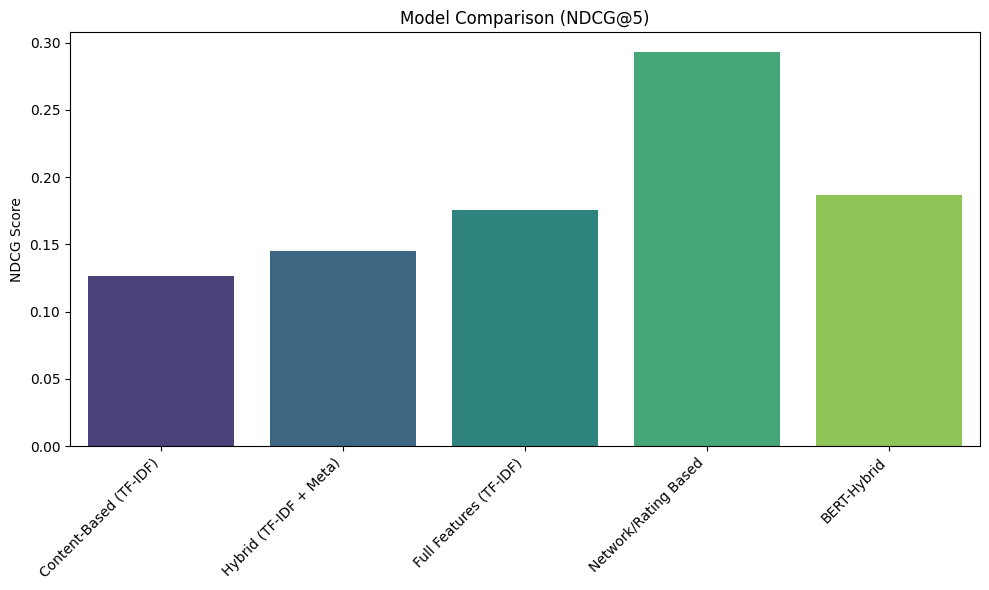

In [9]:
# ==============================================================================
# 4. MODEL EVALUATION (Final Fixed Version)
# ==============================================================================

print("\n--- Model Evaluation ---")

def evaluate_model(similarity_matrix, model_name, k=5, eval_df=None, full_data_df=None, metadata_cols=None):
    """
    Evaluates a recommendation model using NDCG@k.
    Uses a pseudo ground truth based on network and metadata similarity.

    Args:
        similarity_matrix (np.array): The precomputed similarity matrix (n_samples, n_samples).
        model_name (str): Name of the model for logging.
        k (int): Number of top recommendations to consider for NDCG.
        eval_df (pd.DataFrame): The DataFrame containing the test set for evaluation.
        full_data_df (pd.DataFrame): The full DataFrame from which the similarity matrix was built.
        metadata_cols (list): List of columns used for metadata features (e.g., PCA components).

    Returns:
        float: Mean NDCG@k score.
    """
    if eval_df is None or full_data_df is None or metadata_cols is None:
        print(f"Error: Missing evaluation data for {model_name}. Skipping evaluation.")
        return 0.0

    ndcgs = []
    # Get indices that exist in both test_df and similarity matrix
    test_indices_in_full_df = [idx for idx in eval_df.index if idx in full_data_df.index and idx < similarity_matrix.shape[0]]

    if not test_indices_in_full_df:
        print(f"No valid test indices found for {model_name}. Skipping evaluation.")
        return 0.0

    num_eval_samples = min(200, len(test_indices_in_full_df))
    sampled_test_indices = np.random.choice(test_indices_in_full_df, num_eval_samples, replace=False)

    for idx in sampled_test_indices:
        # Create pseudo ground truth
        if 'original_network' not in full_data_df.columns or not metadata_cols:
            print(f"Warning: Required columns missing. Cannot create pseudo ground truth.")
            continue

        current_network = full_data_df.loc[idx, 'original_network']
        same_network = (full_data_df['original_network'] == current_network).values

        # Calculate metadata similarity
        try:
            current_metadata = full_data_df.loc[idx, metadata_cols].values.astype(float)
            metadata_all = full_data_df[metadata_cols].values.astype(float)

            # Ensure proper array shapes
            current_metadata = np.atleast_2d(current_metadata)
            metadata_all = np.atleast_2d(metadata_all)

            # Calculate distances safely
            distances = np.sqrt(np.sum((metadata_all - current_metadata) ** 2, axis=1))
            similarity_threshold = np.mean(distances)
            similar_metadata = (distances < similarity_threshold)
        except Exception as e:
            print(f"Error calculating metadata similarity: {e}")
            continue

        # Create ground truth vector
        y_true = (same_network & similar_metadata).astype(int)
        if idx < len(y_true):  # Double check bounds
            y_true[idx] = 0  # Exclude self

        # Get similarity scores safely
        if idx >= similarity_matrix.shape[0]:
            continue

        sim_scores = similarity_matrix[idx].copy()
        if idx < len(sim_scores):  # Double check bounds
            sim_scores[idx] = -1  # Exclude self

        # Calculate NDCG only if we have relevant items
        if np.sum(y_true) > 0:
            try:
                ndcg = ndcg_score([y_true], [sim_scores], k=k)
                ndcgs.append(ndcg)
            except:
                ndcgs.append(0.0)
        else:
            ndcgs.append(0.0)

    mean_ndcg = np.mean(ndcgs) if ndcgs else 0.0
    print(f"{model_name: <35} NDCG@{k}: {mean_ndcg:.4f}")
    return mean_ndcg

print("\nInitial Model Evaluation Results:")
results = {
    "Content-Based (TF-IDF)": evaluate_model(models['content_based'], "Content-Based (TF-IDF)",
                                             eval_df=test_df, full_data_df=final_df, metadata_cols=metadata_cols),
    "Hybrid (TF-IDF + Meta)": evaluate_model(models['hybrid_tfidf_meta'], "Hybrid (TF-IDF + Meta)",
                                             eval_df=test_df, full_data_df=final_df, metadata_cols=metadata_cols),
    "Full Features (TF-IDF)": evaluate_model(models['full_feature'], "Full Features (TF-IDF)",
                                             eval_df=test_df, full_data_df=final_df, metadata_cols=metadata_cols),
    "Network/Rating Based": evaluate_model(models['network_rating'], "Network/Rating Based",
                                           eval_df=test_df, full_data_df=final_df, metadata_cols=metadata_cols)
}

if 'bert_hybrid' in models:
    results["BERT-Hybrid"] = evaluate_model(models['bert_hybrid'], "BERT-Hybrid",
                                            eval_df=test_df, full_data_df=final_df, metadata_cols=metadata_cols)

# Plot results
plt.figure(figsize=(10, 6))
sns.barplot(x=list(results.keys()), y=list(results.values()), palette='viridis')
plt.title('Model Comparison (NDCG@5)')
plt.ylabel('NDCG Score')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [10]:
# ==============================================================================
# 5. MODEL OPTIMIZATION (Weight Tuning for Hybrid Model)
# ==============================================================================

print("\n--- Model Optimization (Weight Tuning) ---")
print("Optimizing weights for the Full Feature model (TF-IDF based initially).")

# Define k for NDCG@k
k = 5  # Number of recommendations to evaluate

best_score = -1
best_weights = (0.6, 0.3, 0.1) # Default initial weights

# Define a range of weights to test. Sum should be ~1.0
# Content, Metadata, Categorical
weight_ranges = {
    'content': [0.5, 0.6, 0.7, 0.8],
    'metadata': [0.1, 0.2, 0.3, 0.4],
    'categorical': [0.0, 0.1, 0.2]
}

# Grid search for optimal weights
for content_w in weight_ranges['content']:
    for meta_w in weight_ranges['metadata']:
        for cat_w in weight_ranges['categorical']:
            # Ensure weights sum approximately to 1.0
            current_sum = content_w + meta_w + cat_w
            if not (0.95 <= current_sum <= 1.05): # Allow for small floating point deviations
                continue

            print(f"  Testing weights: Content={content_w:.1f}, Metadata={meta_w:.1f}, Categorical={cat_w:.1f}")

            # Create combined features with current weights
            current_features = hstack([
                content_tfidf_features * content_w,
                metadata_features * meta_w,
                cat_features * cat_w
            ]).tocsr()
            current_sim = cosine_similarity(current_features)

            score = evaluate_model(current_sim, f"  Trial w=({content_w},{meta_w},{cat_w})",
                                   eval_df=test_df, full_data_df=final_df, metadata_cols=metadata_cols)

            if score > best_score:
                best_score = score
                best_weights = (content_w, meta_w, cat_w)
                print(f"  New best score: {best_score:.4f} with weights {best_weights}")

print(f"\nOptimal Weights found: Content={best_weights[0]:.1f}, Metadata={best_weights[1]:.1f}, Categorical={best_weights[2]:.1f}")
print(f"Best NDCG@{k} achieved: {best_score:.4f}")

# Train final model with optimal weights
final_combined_features = hstack([
    content_tfidf_features * best_weights[0],
    metadata_features * best_weights[1],
    cat_features * best_weights[2]
]).tocsr()
final_sim_matrix = cosine_similarity(final_combined_features)
print("\nFinal similarity matrix computed using optimal weights.")


# If BERT-Hybrid was used, also optimize its weights
if 'bert_hybrid' in models:
    print("\nOptimizing weights for the BERT-Hybrid model.")
    best_bert_score = -1
    best_bert_weights = (0.7, 0.2, 0.1) # Default initial BERT weights

    for bert_w in weight_ranges['content']: # Re-using content weights range for BERT
        for meta_w in weight_ranges['metadata']:
            for cat_w in weight_ranges['categorical']:
                current_sum = bert_w + meta_w + cat_w
                if not (0.95 <= current_sum <= 1.05):
                    continue

                print(f"  Testing BERT weights: BERT={bert_w:.1f}, Metadata={meta_w:.1f}, Categorical={cat_w:.1f}")
                current_bert_features = hstack([
                    bert_csr * bert_w,
                    metadata_features * meta_w,
                    cat_features * cat_w
                ]).tocsr()
                current_bert_sim = cosine_similarity(current_bert_features)

                score = evaluate_model(current_bert_sim, f"  Trial BERT w=({bert_w},{meta_w},{cat_w})",
                                       eval_df=test_df, full_data_df=final_df, metadata_cols=metadata_cols)

                if score > best_bert_score:
                    best_bert_score = score
                    best_bert_weights = (bert_w, meta_w, cat_w)
                    print(f"  New best BERT score: {best_bert_score:.4f} with weights {best_bert_weights}")

    print(f"\nOptimal BERT Weights found: BERT={best_bert_weights[0]:.1f}, Metadata={best_bert_weights[1]:.1f}, Categorical={best_bert_weights[2]:.1f}")
    print(f"Best BERT NDCG@{k} achieved: {best_bert_score:.4f}")

    # Choose the overall best similarity matrix based on evaluation scores
    if best_bert_score > best_score:
        print("\nBERT-Hybrid model performed better. Using BERT-Hybrid for final recommendations.")
        final_sim_matrix = cosine_similarity(hstack([
            bert_csr * best_bert_weights[0],
            metadata_features * best_bert_weights[1],
            cat_features * best_bert_weights[2]
        ]).tocsr())
        optimal_weights_for_saving = best_bert_weights
        model_type_for_saving = "BERT-Hybrid"
    else:
        print("\nTF-IDF based Full Features model performed better or equally. Using it for final recommendations.")
        optimal_weights_for_saving = best_weights
        model_type_for_saving = "TF-IDF-Hybrid"
else:
    optimal_weights_for_saving = best_weights
    model_type_for_saving = "TF-IDF-Hybrid"


--- Model Optimization (Weight Tuning) ---
Optimizing weights for the Full Feature model (TF-IDF based initially).
  Testing weights: Content=0.5, Metadata=0.3, Categorical=0.2
  Trial w=(0.5,0.3,0.2)             NDCG@5: 0.2026
  New best score: 0.2026 with weights (0.5, 0.3, 0.2)
  Testing weights: Content=0.5, Metadata=0.4, Categorical=0.1
  Trial w=(0.5,0.4,0.1)             NDCG@5: 0.1706
  Testing weights: Content=0.6, Metadata=0.2, Categorical=0.2
  Trial w=(0.6,0.2,0.2)             NDCG@5: 0.1772
  Testing weights: Content=0.6, Metadata=0.3, Categorical=0.1
  Trial w=(0.6,0.3,0.1)             NDCG@5: 0.1653
  Testing weights: Content=0.6, Metadata=0.4, Categorical=0.0
  Trial w=(0.6,0.4,0.0)             NDCG@5: 0.1639
  Testing weights: Content=0.7, Metadata=0.1, Categorical=0.2
  Trial w=(0.7,0.1,0.2)             NDCG@5: 0.1664
  Testing weights: Content=0.7, Metadata=0.2, Categorical=0.1
  Trial w=(0.7,0.2,0.1)             NDCG@5: 0.1593
  Testing weights: Content=0.7, Metadat

In [11]:
print("\n--- Model Saving ---")

# Prepare columns to save - only include those that exist in final_df
columns_to_save = ['title', 'original_network', 'content_rating']  # These are the essential columns we know exist
additional_cols = [col for col in ['genres', 'directors', 'screenwriters'] if col in final_df.columns]
columns_to_save.extend(additional_cols)

# Prepare model artifacts dictionary with only the models that exist
model_artifacts = {
    'similarity_matrix': final_sim_matrix,
    'scaler': scaler,
    'pca_scaler': pca_scaler if 'pca_scaler' in locals() else None,
    'pca_model': pca if 'pca' in locals() else None,
    'pca_numerical_cols': pca_numerical_cols if 'pca_numerical_cols' in locals() else [],
    'mlb_genres': mlb_genres,
    'optimal_weights': optimal_weights_for_saving,
    'model_type': model_type_for_saving,
    'drama_data': final_df[columns_to_save].copy(),
    'numerical_features_for_scaling': numerical_features_for_scaling,
    'cat_feature_cols': cat_feature_cols
}

# Only add TF-IDF models that were actually created
if tfidf_syn_model is not None:
    model_artifacts['tfidf_syn_model'] = tfidf_syn_model
if tfidf_reviews_model is not None:
    model_artifacts['tfidf_reviews_model'] = tfidf_reviews_model
if tfidf_tags_model is not None:
    model_artifacts['tfidf_tags_model'] = tfidf_tags_model
if tfidf_directors_model is not None:
    model_artifacts['tfidf_directors_model'] = tfidf_directors_model
if tfidf_genres_model is not None:
    model_artifacts['tfidf_genres_model'] = tfidf_genres_model

# Add BERT model if it was used
if bert_model is not None:
    model_artifacts['bert_model'] = bert_model

joblib.dump(model_artifacts, 'drama_recommender_v2.joblib')
print("Model artifacts saved to 'drama_recommender_v2.joblib'")


--- Model Saving ---
Model artifacts saved to 'drama_recommender_v2.joblib'


In [14]:
joblib.dump(final_df, 'final_preprocessed_df.pkl')

['final_preprocessed_df.pkl']

In [12]:
# ==============================================================================
# 7. INFERENCE EXAMPLE
# ==============================================================================

print("\n--- Inference Example ---")

def recommend_dramas(title, n=5, model_path='drama_recommender_v2.joblib'):
    """
    Recommends dramas similar to a given title.

    Args:
        title (str): The title of the drama to find recommendations for.
        n (int): Number of recommendations to return.
        model_path (str): Path to the saved model artifacts.

    Returns:
        pd.DataFrame: DataFrame of recommended dramas with similarity scores.
    """
    try:
        artifacts = joblib.load(model_path)
    except FileNotFoundError:
        return "Error: Model file not found. Please ensure 'drama_recommender_v2.joblib' exists."
    except Exception as e:
        return f"Error loading model: {e}"

    similarity_matrix = artifacts['similarity_matrix']
    drama_data = artifacts['drama_data']

    # Get available TF-IDF models
    tfidf_syn_model = artifacts.get('tfidf_syn_model')
    tfidf_reviews_model = artifacts.get('tfidf_reviews_model')
    tfidf_tags_model = artifacts.get('tfidf_tags_model')
    tfidf_directors_model = artifacts.get('tfidf_directors_model')
    tfidf_genres_model = artifacts.get('tfidf_genres_model')

    bert_model = artifacts.get('bert_model') # Get BERT model if it was saved
    scaler = artifacts['scaler']
    pca_scaler = artifacts.get('pca_scaler')
    pca_model = artifacts.get('pca_model')
    pca_numerical_cols = artifacts.get('pca_numerical_cols', [])
    mlb_genres = artifacts['mlb_genres']
    optimal_weights = artifacts['optimal_weights']
    model_type = artifacts.get('model_type', 'TF-IDF-Hybrid')
    numerical_features_for_scaling = artifacts.get('numerical_features_for_scaling', [])
    cat_feature_cols = artifacts.get('cat_feature_cols', [])

    # Get the titles for matching
    titles = drama_data['title'].values

    # Find the index of the input title using fuzzy matching for robustness
    matched_title, score = process.extractOne(title, titles)
    if score < 80: # Threshold for a good match (adjust as needed)
        similar_titles = [t for t in titles if title.lower() in t.lower()]
        if similar_titles:
            return f"Drama '{title}' not found exactly. Did you mean: {', '.join(similar_titles[:5])}?"
        return f"Drama '{title}' not found in database."

    idx = np.where(titles == matched_title)[0]
    if len(idx) == 0: # Should not happen if process.extractOne finds a match
        return f"Internal error: Matched title '{matched_title}' not found in drama_data."

    drama_idx = idx[0]

    # Get similarity scores for the chosen drama
    sim_scores = list(enumerate(similarity_matrix[drama_idx]))

    # Sort the dramas by similarity score in descending order
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)

    # Get the indices of the top N similar dramas (excluding itself)
    top_indices = [i for i, score in sim_scores[1:n+1]] # [1:n+1] to exclude the first (itself)

    # Prepare results DataFrame
    results = drama_data.iloc[top_indices].copy()
    results['similarity_score'] = [sim_scores[i][1] for i in range(1, n + 1)] # Get actual scores for top N

    # Format the output nicely
    results = results[['title', 'original_network', 'content_rating', 'similarity_score']]
    results['similarity_score'] = results['similarity_score'].round(4)
    return results

# Example usage
print("\nRecommendation Examples:")
print("1. For 'Goblin':")
print(recommend_dramas('Goblin', n=3))

print("\n2. For a romance drama (using a title from the dataset):")
# Find a romance drama from the dataset for example
romance_dramas = final_df[final_df['flattened_genres'].str.contains('romance', case=False, na=False)]
if not romance_dramas.empty:
    romance_title = romance_dramas.iloc[0]['title']
    print(f"Searching for dramas similar to '{romance_title}':")
    print(recommend_dramas(romance_title, n=3))
else:
    print("No romance dramas found in the dataset for example usage.")

print("\n3. For a drama not exactly in the database (fuzzy match example):")
print(recommend_dramas('Goblin the Great', n=3)) # Should match 'Goblin'
print(recommend_dramas('Unknown Drama 123', n=3)) # Should return not found


--- Inference Example ---

Recommendation Examples:
1. For 'Goblin':
                title                            original_network  \
1318     Bite Sisters                                         SBS   
1959  The Sweet Blood  Naver TV Cast, vLive, Naver TV Cast, vLive   
917      Dear My Name  Naver TV Cast, vLive, Naver TV Cast, vLive   

     content_rating  similarity_score  
1318            15+            0.6907  
1959            15+            0.6873  
917             15+            0.6802  

2. For a romance drama (using a title from the dataset):
Searching for dramas similar to 'When Life Gives You Tangerines':
                   title original_network content_rating  similarity_score
182  Recipe for Farewell           Watcha            13+            0.6530
954  My First First Love          Netflix            13+            0.6519
309         Call It Love          Disney+            13+            0.6128

3. For a drama not exactly in the database (fuzzy match example):
  

In [15]:
pip list

Package                               Version
------------------------------------- -------------------
absl-py                               1.4.0
accelerate                            1.9.0
aiofiles                              24.1.0
aiohappyeyeballs                      2.6.1
aiohttp                               3.12.14
aiosignal                             1.4.0
alabaster                             1.0.0
albucore                              0.0.24
albumentations                        2.0.8
ale-py                                0.11.2
altair                                5.5.0
annotated-types                       0.7.0
antlr4-python3-runtime                4.9.3
anyio                                 4.9.0
anywidget                             0.9.18
argon2-cffi                           25.1.0
argon2-cffi-bindings                  21.2.0
array_record                          0.7.2
arviz                                 0.22.0
astropy                               7.1.0
astropy

In [16]:
joblib.dump(pd.read_csv("clean_drama_dataset.csv"), 'clean_drama_dataset.pkl')

['clean_drama_dataset.pkl']